# Generating a SARS-CoV Mpro chemical space with Reinvent

Installation

- Install Conda

- Clone this Git repository: https://github.com/tblaschke/Reinvent-2.0

- Open a shell, and go to the repository and create the Conda environment:

In [ ]:
 # conda env create -f reinvent.yml

- Activate the environment:

In [ ]:
# conda activate reinvent

Run jupyter notebook

- Execute jupyter: jupyter notebook

In [1]:
# load dependencies
import os
import re
import json
import tempfile

# --------- change these path variables as required
reinvent_dir = os.path.expanduser("/mnt/NVMe/Reinvent2-master")
reinvent_env = os.path.expanduser("/home/hazemaj/anaconda3/envs/reinvent_shared.v2.1")
output_dir = os.path.expanduser("/mnt/NVMe/Reinvent2-master/production/SARS_CoV-2_Mpro_5_min_fame")
output_dir_TL = os.path.expanduser("/mnt/NVMe/Reinvent2-master/production/SARS_CoV-2_Mpro_5_min_fame/TL")
output_dir_RL = os.path.expanduser("/mnt/NVMe/Reinvent2-master/production/SARS_CoV-2_Mpro_5_min_fame/RL")
output_dir_sampling = os.path.expanduser("/mnt/NVMe/Reinvent2-master/production/SARS_CoV-2_Mpro_5_min_fame/sampling")

# --------- do not change
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir_TL)
except FileExistsError:
    pass

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir_RL)
except FileExistsError:
    pass

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir_sampling)
except FileExistsError:
    pass

In [2]:
#For Transfer Learning: run next cells
#For Reinforcement Learning: Go to Reinforcement Learning and run RL cells
#For Sampling: go to Sampling and run the cells

## Transfer Learning

In [3]:
# initialize the dictionary
configuration = {
    "version": 2,                          # we are going to use REINVENT's newest release
    "run_type": "transfer_learning"        # other run types: "scoring", "validation",
                                           #                  "transfer_learning",
                                           #                  "reinforcement_learning" and
                                           #                  "create_model"
}

In [4]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "http://127.0.0.1",          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_path": os.path.join(output_dir_TL, "progress.log"), # where the run's output is stored
    "job_name": "Transfer Learning", # set an arbitrary job name for identification
    "job_id": "TL1"                       # only relevant if "recipient" is set to "remote"
}

- Define parameters for Transfer Learning
- Define the input prior (original prior trained with ChEMBL)
- Define the output focused agent path
- Define the Mpro chemical space (selection of active molecules from ChEMBL and CovidMoonshot) for which Transfer Leraning should be used
- Define the number of epochs

In [5]:
adaptive_lr_config = {
      "mode": "constant", # other modes: "exponential", "adaptive", "constant"
      "gamma": 0.8,
      "step": 1,
      "start": 5E-4,
      "min": 1E-5,
      "threshold": 1E-4,
      "average_steps": 4,
      "patience": 8,
      "restart_value": 1E-5,
      "sample_size": 10000,
      "restart_times": 0
    }

In [6]:
output_model_path = os.path.join(output_dir_TL, "focused.agent") \
# The final focused agent will be named "focused.agent"
# The intermediate steps will be named "focused.agent.1", "focused.agent.2", "focused.agent.3" and etc.

# add the "parameters" block
configuration["parameters"] = {
    "input_model_path": os.path.join(reinvent_dir,        # path to prior or trained agent
                               "data",
                               "augmented.prior"),
    "output_model_path": output_model_path,                # location to store the focused agent
    "input_smiles_path": os.path.join(output_dir,        # path to input smiles                     
                               "SARS-CoV-2_ChemSpace.smi"),# this is a dataset consisting of non-covalent Mpro inhibitors
    "save_every_n_epochs": 1,      # how often to save the focused Agent. Here its stored after each epoch
    "batch_size": 128,             # batch size the input data
    "num_epochs": 20,              # number of epochs to focus the agent for
    "standardize": True,           # the input may contain SMILES strings that are invalid according to the agent
                                   # this atempts to clean up the input dataset
    "randomize": True,             # this triggers data augmentation which is quite important for small datasets
    "adaptive_lr_config": adaptive_lr_config        # setting the learning rate behavior
}

In [7]:
# write the configuration file to the disc
configuration_JSON_path = os.path.join(output_dir_TL, "transfer_learning_config.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=True)

Run REINVENT
Now it is time to execute REINVENT locally.

### execute REINVENT
python <your_path>/input.py <config>.json

In [8]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!python {reinvent_dir}/input.py {configuration_JSON_path}

### Analyse the results

In order to analyze the run in a more intuitive way, we can use tensorboard:

- go to the root folder of the output
cd "your_path"/SARS_CoV-2_Mpro_5_min_fame/TL

- make sure, you have activated the proper environment<br>
$conda activate reinvent

- start tensorboard<br>
$tensorboard --logdir progress.log

# Reinforcement Learning

In [9]:
# initialize the dictionary
configuration = {
    "version": 2,                          # we are going to use REINVENT's newest release
    "run_type": "reinforcement_learning"   # other run types: "sampling", "validation",
                                           #                  "transfer_learning",
                                           #                  "scoring" and "create_model"
}

In [10]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "http://127.0.0.1",          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_frequency": 10,               # log every x-th steps
    "logging_path": os.path.join(output_dir_RL, "progress.log"), # load this folder in tensorboard
    "resultdir": os.path.join(output_dir_RL, "results"),         # will hold the compounds (SMILES) and summaries
    "job_name": "Reinforcement Learning",                # set an arbitrary job name for identification
    "job_id": "RL1"                       # only relevant if "recipient" is set to "remote"
}

In [11]:
# add the "parameters" block
configuration["parameters"] = {}

# add a "diversity_filter"
configuration["parameters"]["diversity_filter"] =  {
    "name": "IdenticalMurckoScaffold",     # other options are: "IdenticalTopologicalScaffold", 
                                           #                    "NoFilter" and "ScaffoldSimilarity"
                                           # -> use "NoFilter" to disable this feature
    "nbmax": 25,                           # the bin size; penalization will start once this is exceeded
    "minscore": 0.4,                       # the minimum total score to be considered for binning
    "minsimilarity": 0.4                   # the minimum similarity to be placed into the same bin
}

# prepare the inception (we do not use it in this example, so "smiles" is an empty list)
configuration["parameters"]["inception"] = {
    "smiles": [],                          # fill in a list of SMILES here that can be used (or leave empty)
    "memory_size": 100,                    # sets how many molecules are to be remembered
    "sample_size": 10                      # how many are to be sampled each epoch from the memory
}

# set all "reinforcement learning"-specific run parameters
configuration["parameters"]["reinforcement_learning"] = {
    "prior": os.path.join(reinvent_dir, "data/augmented.prior"), # path to the pre-trained model
    "agent": os.path.join(output_dir_TL, "focused.agent.19"), # path to the pre-trained model
    "n_steps": 500,                        # the number of epochs (steps) to be performed; often 1000
    "sigma": 128,                          # used to calculate the "augmented likelihood", see publication
    "learning_rate": 0.0001,               # sets how strongly the agent is influenced by each epoch
    "batch_size": 128,                     # specifies how many molecules are generated per epoch
    "reset": 0,                            # if not '0', the reset the agent if threshold reached to get
                                           # more diverse solutions
    "reset_score_cutoff": 0.5,             # if resetting is enabled, this is the threshold
    "margin_threshold": 50                 # specify the (positive) margin between agent and prior
}

In [12]:
# prepare the scoring function definition and add at the end
scoring_function = {
    "name": "custom_product",              # this is our default one (alternative: "custom_sum")
    "parallel": True,                     # sets whether components are to be executed
                                           # in parallel; note, that python uses "False" / "True"
                                           # but the JSON "false" / "true"

    # the "parameters" list holds the individual components
    "parameters": [

    # add component: calculate the QED drug-likeness score (using RDkit)
    {
        "component_type": "qed_score",
        "name": "QED Score",                   # arbitrary name for the component
        "weight": 1,                           # the weight of the component (default: 1)
        "model_path": None,                    # not required; note, this is "null" in JSON
        "smiles": [],                          # not required
        "specific_parameters": None            # not required; note, this is "null" in JSON
    },
        
    # add component: enforce the match to a given substructure
    {
        "component_type": "matching_substructure", 
        "name": "Matching substructure",       # arbitrary name for the component
        "weight": 1,                           # the weight of the component (default: 1)
        "model_path": None,                    # not required; note, this is "null" in JSON
        "smiles": ["Brc1ccc2c(c1)CCCO2","CC(=O)N(Cc1ccsc1)c1ccc(N(C)C)cc1","Cc1ccc2nc(N)sc2c1","Cc1ccc2ncsc2c1","CC(C(N)=O)c1cccc(Cl)c1","Cc1ccccc1C1CCC1","Cc1cncc2ccccc12","Cc1nc2n(n1)CC(C(N)=O)CC2","Cc1nc2n(n1)CCCC2","CC(C)(C(N)=O)c1ccccc1","Clc1cc(Cl)c2c(c1)CCCO2","Clc1cc2c(cc1Cl)NCCC2","Clc1cc2c(cc1Cl)OCCC2","Clc1ccc(Cl)cc1","Clc1ccc2c(c1)C=CCC2","Clc1ccc2c(c1)CCCC2","Clc1ccc2c(c1)CCCN2","Clc1ccc2c(c1)CCCO2","Clc1ccc2c(c1)CCCS2","CC(C)(C)NC=O","Clc1ccc2c(c1)CCNC2","Clc1ccc2c(c1)CCO2","Clc1ccc2c(c1Cl)OCCC2","Clc1cccc(CN2CCNCC2)c1","Clc1cccc(Cc2ccn[nH]2)c1","Clc1cccc(Cl)c1","Clc1cccc(N2CCNCC2)c1","Clc1cccc(NCCC2CCCCC2)c1","Clc1cccc(Oc2cccnc2)c1","Clc1cccc2c1OCC2","CC(C)(C)c1ccc(NC(=O)c2cocn2)cc1","Clc1ccccc1Cl","Cn1nc2n(c(=O)c1=O)CCC2","FC(F)c1ccc(Cl)c(Cl)c1","Fc1cc2c(cc1Cl)CCCO2","Fc1ccc(Cl)cc1","Fc1ccc(F)cc1","Fc1ccc2cnccc2c1","Fc1cccc(F)c1","Fc1ccccc1Cl","N#Cc1ccc2cncc(N)c2c1","N#Cc1ccc2cnccc2c1","CC(C)(C)c1cncs1","NC(=O)C1CCOc2ccc(Cl)cc21","NC(=O)CN1CCN(C2CC2)C1=O","NC(=O)Cc1ccc(Cl)c(Cl)c1","NC(=O)Cn1ccnc1","NC(=O)Cn1nc2n(c(=O)c1=O)CCC2","NC(=O)N(CCC1CCCCC1)c1cccc(Cl)c1","NC(=O)[C@@H]1CCOc2ccc(Cl)cc21","NC(=O)[C@H]1CCOc2ccc(Cl)cc21","NC(=O)c1cn[nH]c1S(N)(=O)=O","NC1CC(F)(F)C1","NC1CCOCC1","NCC1CCCO1","CC1CCOc2ccc(Cl)cc21","NCc1ccc(Cl)c(Cl)c1","Nc1ccc(C(F)(F)F)cn1","Nc1cncc2c1CCC2","Nc1cncc2c1CNCC2","Nc1cncc2ccc(F)cc12","Nc1cncc2ccccc12","Nc1cncc2ccncc12","CC1Cn2nccc2CN1","Nc1cncc2cnccc12","Nn1nnc2ccccc21","O=C(Cc1ccc(Cl)cc1)Nc1cncc2ccccc12","O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12","O=C(Cc1cccc(F)c1)Nc1cncc2ccccc12","O=C(Cc1ccccc1)Nc1cncc2ccccc12","CC1Cn2nccc2CN1C=O","O=C(Cc1cccnc1)NC1CCOC1","O=C(Cc1cccnc1)NC1COC1","O=C(Cc1cncc2ccccc12)NCCC1CCCCC1","O=C(Cn1nnc2ccccc21)NCc1ccsc1","O=C(NCCC1CCCCC1)Nc1cncc2ccccc12","O=C(Nc1ccccc1)C1CC1","O=C(Nc1cccnc1)C1CCOc2ccc(Cl)cc21","O=C(c1ccco1)N1CCNCC1","O=C(c1cncc2ccccc12)N1CCNCC1","O=C1CC(Cc2cccc(Cl)c2)N1","O=C1CC(Oc2cc(O)cc(Cl)c2)N1","O=C1CCCCN1c1cncc2ccccc12","O=C1CCc2cc(Br)ccc2N1","O=C1CCc2cc(Cl)cc(Cl)c2N1","O=C1NCCN1C1CC1","O=CN(CCC1CCCCC1)c1cccc(Cl)c1","O=CN1CCN(Cc2cccc(Cl)c2)CC1","O=CN1CCN(c2cccc(Cl)c2)CC1","O=CNC1CC(F)(F)C1","O=CNC1CCOCC1","O=CNC1COC1","O=CNc1cncc2ccc(F)cc12","O=CNc1cncc2ccccc12","O=CNc1cncc2ccncc12","O=CNc1cncc2cnccc12","O=COc1cncc(Cl)c1","O=c1cccc(O)[nH]1","OCC1CCOc2ccc(Cl)cc21","OCc1ccc(Cl)c(Cl)c1","CCNc1ccc(C#N)cn1","Oc1cncc(Cl)c1","c1cc2c(cn1)CCC2","c1cc2c(cn1)CCNC2","c1cc2ccncc2cn1","c1cc2cnccc2cn1","c1ccc(C2CCCC2)cc1","CCOc1c(C)cccc1Cl","c1ccc2cnccc2c1","c1cnc2ccncc2c1","CCOc1ccccc1Cl","CCS(=O)(=O)N1CCNCC1","CCc1ccc(Cl)c(Cl)c1","CC(=O)N1CCNCC1","CN(C)Cc1ccc(Cl)c(Cl)c1","CN(C)c1ccc(N(C=O)Cc2ccsc2)cc1","CN(C)c1ccc(NC(=O)Cn2nnc3ccccc32)cc1","CN(C)c1ccc(NCc2ccsc2)cc1","CN(C)c1cccnc1","CN1CCCc2cc(Cl)ccc21","CC(=O)N1Cc2ccnn2CC1C","CN1CCN(C2CC2)C1=O","CNC(=O)Cn1ccnc1","CNC(=O)c1cn[nH]c1S(N)(=O)=O","CNCc1ccc(Cl)c(Cl)c1","CNCc1cccc2ccccc12","CNc1ccc(NC(=O)Cn2nnc3ccccc32)cc1","COC(=O)C1(N)CCCC1","COC(=O)C1(NC=O)CCCC1","COC(=O)C1CC(N)C1","COC(=O)C1CC(NC=O)C1","COC(=O)C1CCC1","COC(=O)C1CCCC1","COC(=O)[C@@H]1CC[C@H](N)C1","COC(=O)[C@@H]1CC[C@H](NC=O)C1","CC(=O)NCc1ccc(Cl)c(Cl)c1","COC1CCOc2ccc(Cl)cc21","COCc1ccc(Cl)c(Cl)c1","COc1cc(Br)ccc1N","COc1cc(Cl)cc(OC2CC(=O)N2)c1","COc1cc(Cl)nc(N)n1","COc1cc(Cl)ncn1","COc1ccc(Br)cn1","COc1ccc(Cl)cc1","COc1ccc(Cl)cc1C","CC(=O)Nc1cncc2ccccc12","COc1ccc2cncc(N)c2c1","COc1ccc2cncc(NC=O)c2c1","COc1ccc2cnccc2c1","COc1cccc(N2CCN(C=O)CC2)c1","COc1cccc(N2CCNCC2)c1","COc1ccccn1","COc1ncc(Br)cc1N","CC(=O)Nc1cncc2ccncc12","CS(=O)(=O)c1ccc2cnccc2c1","Cc1cc(Cl)cc(C#N)c1","Cc1cc(Cl)cc(C(C)C(N)=O)c1","Cc1cc(Cl)cc(Cl)c1","Cc1cc(Cl)cc2c1OCC2","CC(=O)Nc1cncc2cnccc12","Cc1cc(Cl)ccc1Cl","Cc1cc(Cl)ccc1F","Cc1cc(Cl)ccn1","Cc1cc(F)cc(F)c1","Cc1cc(F)ccc1F","Cc1ccc(C)c(Cl)c1","Cc1ccc(Cl)c(Cl)c1","Cc1ccc(Cl)c(F)c1","Cc1ccc(F)c(Cl)c1"],              # a match with this substructure is required
        "specific_parameters": None            # not required; note, this is "null" in JSON
    },
    
    # add component: Get away from the listed structures - SARS-CoV-2 Mpro known inhibitors
    {
        "component_type": "jaccard_distance", 
        "name": "Jaccard distance",         # arbitrary name for the component
        "weight": 1,                           # the weight of the component (default: 1)
        "model_path": None,                    # not required; note, this is "null" in JSON
        "smiles": ['Nc1ccc(O)c2ncccc12', 'Cc1c(-c2cnccn2)ssc1=S', 'O=C(Oc1cncc(Cl)c1)c1ccco1', 'O=C(Oc1cncc(Br)c1)c1ccco1', 'O=C(Oc1cncc(Cl)c1)c1cscn1', 'Cn1sc(=O)n(Cc2ccccc2)c1=O', 'CN1CC[C@@]2(C)c3cc(O)ccc3N(C)[C@@H]12', 'Nc1ccc2cc3ccc(N)cc3nc2c1', 'N#Cc1cnn(C(=O)c2cccs2)c1C1CC1', 'Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1', 'COc1cc(C(=S)N2CCOCC2)ccc1O', 'c1ccc2sc(SNC3CCCCC3)nc2c1', 'O=c1oc(Nc2ccccc2)nc2ccccc12', 'Cc1nnn(NC(=O)Cc2cccc(Cl)c2)c1C', 'Nc1ncc(S(=O)(=O)c2ccc(Cl)cc2)c(N)n1', 'COc1cccc(C(=O)Oc2cncc(Cl)c2)c1', 'CCOC(=O)Cc1ccc(-c2ccccc2)cc1', 'O=C(Oc1cncc(Cl)c1)c1cccc2[nH]ccc12', 'COc1cc(Cl)cc(OC(=O)Nc2cccnc2)c1', 'Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1', 'O=C(Oc1cncc(Cl)c1)c1cc2ccccc2o1', 'O=C(Oc1cncc(Cl)c1)c1cc2ccccc2[nH]1', 'O=C(Oc1cncc(Cl)c1)c1cc2ccccc2s1', 'C/N=c1/nc(-c2ccccc2)n(-c2ccccc2)s1', 'CC(CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1', 'Cc1ccc(C)c(-n2sc3cc(F)ccc3c2=O)c1', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2c1CCC2', 'O=C(O)[C@@H](c1ccccc1)N1Cc2ccccc2C1=O', 'N#Cc1ccc(CN2CCC(C3CCNC3)CC2)cc1', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2nc[nH]c12', 'O=C(Cc1cccc(Cl)c1)Nn1cnc2ccccc21', 'O=C(Cc1cccc(Cl)c1)Nc1cnccc1C1CC1', 'O=C(Cc1ccccc1)Nc1cncc2ccccc12', 'O=C(Cc1cccc(Cl)c1)Nn1nnc2ccccc21', 'O=C(Cc1cccc(Cl)c1)Nc1cnc2ccccn12', 'CCCCc1nc(-c2nccn2Cc2ccoc2)c[nH]1', 'CC(=O)N1CCN(CC(=O)Nc2cnccc2C)CC1', 'O=C(CC1Sc2ncnn2C1=O)Nc1ccc(Br)cc1', 'O=C(O)C(c1ccccc1)N1Cc2ccccc2C1=O', 'O=C(Cc1cncc2ccccc12)Nc1cccc(Cl)c1', 'O=C(Cc1cc(Cl)ccn1)Nc1cncc2ccccc12', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2c1CCCN2', 'Cc1ccncc1NC(=O)[C@H]1CCOc2ccc(Cl)cc21', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2ccncc12', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2cnccc12', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2cccnc12', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2c1OCCC2', 'O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12', 'O=C(Cc1ccc(F)cc1)Nc1cncc2ccccc12', 'O=C(Cc1cccc(F)c1)Nc1cncc2ccccc12', 'Cc1cccc(CC(=O)Nc2cncc3ccccc23)c1', 'O=C(Cc1cncc(Cl)c1)Nc1cncc2ccccc12', 'O=C(Cc1ccc(Cl)cn1)Nc1cncc2ccccc12', 'Cc1ccncc1NC(=O)C1CCOc2ccc(Cl)cc21', 'Cc1cc(C)cc(N2C(=O)CC(Sc3nc[nH]n3)C2=O)c1', 'O=C(Cc1ccc(Cl)c(Cl)c1)Nc1cncc2ccccc12', 'O=C(COc1cccc(Cl)c1)Nc1cncc2ccccc12', 'Cc1ccncc1NC(=O)Cc1cc(Cl)cc(S(N)(=O)=O)c1', 'O=C(Cc1ccc(Cl)c(Cl)c1)Nc1cncc2cnccc12', 'O=C(Cc1ccc(Cl)c(Cl)c1)Nc1cncc2ccncc12', 'O=C(Cc1cc(Cl)cc(Cl)c1)Nc1cncc2ccccc12', 'O=C(Cc1ccc(F)c(Cl)c1)Nc1cncc2ccccc12', 'Cc1ccc(CC(=O)Nc2cncc3ccccc23)cc1Cl', 'O=C(Cc1ccc(Cl)c(F)c1)Nc1cncc2ccccc12', 'N#Cc1cccc(CC(=O)Nc2cncc3ccccc23)c1', 'O=C(Cc1cc(F)cc(Cl)c1)Nc1cncc2ccccc12', 'O=C(Cc1cc(F)cc(F)c1)Nc1cncc2ccccc12', 'O=C(Cc1cccc(F)c1F)Nc1cncc2ccccc12', 'O=C(Cc1cc(F)ccc1F)Nc1cncc2ccccc12', 'O=C(Cc1cc(Cl)ccc1F)Nc1cncc2ccccc12', 'O=C(Cc1cc(Cl)ccc1Cl)Nc1cncc2ccccc12', 'C#Cc1cccc(CC(=O)Nc2cncc3ccccc23)c1', 'O=C(Nc1cnccc1CO)C1CCOc2ccc(Cl)cc21', 'O=C(Nc1nncn1C1CC1)C1CCOc2ccc(Cl)cc21', 'O=C(Cc1cccc(Cl)c1)Nn1cnc2ccccc2c1=O', 'O=C(Oc1cncc(Cl)c1)c1ccc(-c2ccc(Cl)cc2)o1', 'Cc1ccc(-n2sc(=O)n(Cc3ccc(F)cc3)c2=O)cc1', 'CC(C)c1ccc2oc3nc(N)c(C(=O)O)cc3c(=O)c2c1', 'O=C(Nc1cncc2ccccc12)C1COc2c(Cl)cccc21', 'COC(=O)c1c(C)nn(C(=O)c2cccs2)c1-c1snnc1C', 'O=C(Nc1cncc2ccccc12)C1COc2ccc(Cl)cc21', 'O=C1C(c2cccc(Cl)c2)CCN1c1cncc2ccccc12', 'COc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12', 'COc1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1', 'O=C1N(Cc2cccc(Cl)c2)CCN1c1nccc2[nH]ncc12', 'NC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'CC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'O=C(Nc1cncc2ccccc12)C(O)c1ccc(Cl)c(Cl)c1', 'N#Cc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1', 'O=C(Nc1cncc2ccccc12)[C@@H]1COc2ccc(Cl)cc21', 'O=[N+]([O-])c1cc(C(F)(F)F)ccc1S(=O)(=O)c1ccc(Cl)cc1', 'OC1OC(c2cccs2)=N/C1=C/c1ccc(N2CCOCC2)s1', 'O=C(Cc1cncc2ccccc12)N1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1=CCCc2ccc(Cl)cc21', 'COc1ccccc1OCCNC(=O)c1cncc2ccccc12', 'O=C(c1cncc2ccccc12)N1CCN(c2ccccc2)CC1', 'O=C(Nc1cncc2ccccc12)C1CCCc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCNc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCOc2ccc(Br)cc21', 'O=C(Cc1cc(Cl)cc2c1OCC2)Nc1cncc2ccccc12', 'O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCOc2ccc(Cl)cc21', 'O=C1C(c2cccc(Cl)c2)CCCN1c1cncc2ccccc12', 'Cc1ccncc1NC(=O)Cc1cc(Cl)cc(OC2CC(=O)N2)c1', 'O=C(Nc1cncc2ccccc12)C1CCSc2ccc(Cl)cc21', 'COC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'CCOc1c(Cl)cccc1CC(=O)Nc1cncc2ccccc12', 'CNC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'O=C(Nc1cncc2ccccc12)C(F)(F)c1ccc(Cl)c(Cl)c1', 'Cn1cnc2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c21', 'O=C(Cc1cccc(C(F)(F)F)c1)Nc1cncc2ccccc12', 'O=C(Nc1cncc2ccccc12)[C@@H]1CCNc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccncc12)[C@H]1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2c1CNCC2)C1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)N1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CNCc2ccc(Cl)cc21', 'O=C(Nc1cncc2cnccc12)[C@@H]1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccncc12)[C@@H]1CCOc2ccc(Cl)cc21', 'OCCn1c(CSc2nc3ccccc3o2)nc2ccc(Cl)cc21', 'Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2', 'CSc1[nH]nc(NC(=O)c2cccs2)c1S(=O)(=O)c1ccccc1', 'O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1', 'O=C(Nc1cncc2cnccc12)C1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccncc12)C1CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccc(F)cc12)C1CCOc2ccc(Cl)cc21', 'O=C(c1cncc2ccccc12)N1CCN(c2cccc(Cl)c2)CC1', 'O=C1CC(C(=O)Nc2cncc3ccccc23)c2cc(Br)ccc2N1', 'C[C@@H]1C[C@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2O1', 'C[C@@H]1COc2ccc(Cl)cc2[C@@H]1C(=O)Nc1cncc2ccccc12', 'C[C@@H]1C[C@@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2O1', 'C[C@H]1COc2ccc(Cl)cc2[C@@H]1C(=O)Nc1cncc2ccccc12', 'C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'Cc1ccncc1NC(=O)Cc1cc(C#N)cc(OC2CC(=O)N2)c1', 'COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2ccccc12', 'O=C(Nc1cccnc1)N(CCC1CCCCC1)c1cccc(Cl)c1', 'O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2cc(F)c(Cl)cc21', 'N[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)[C@@H]1CCNc2cc(Cl)c(Cl)cc21', 'O=C(Nc1cncc2ccc(F)cc12)[C@@H]1CCOc2ccc(Cl)cc21', 'CN1CC[C@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'CN(C)C(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'O=C(Nc1cncc2ccccc12)C1CCOc2cc(F)c(Cl)cc21', 'O=C1C(c2ccc(Cl)c(Cl)c2)CCCN1c1cncc2ccccc12', 'O=C(Nc1cncc2ccccc12)C1CCOc2c(Cl)cc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCNc2cc(Cl)c(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCOc2cc(Cl)c(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCOc2c1ccc(Cl)c2Cl', 'O=C(Nc1cncc2ccccc12)[C@]1(O)CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCOc2c(O)cc(Cl)cc21', 'O=C1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2N1', 'CN1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'Cc1c(Cl)ccc2c1[C@H](C(=O)Nc1cncc3ccccc13)CCO2', 'CCn1c(-c2nonc2N)nc2cncc(CNC3CCNCC3)c21', 'CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'O=C(c1cncc2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1', 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)CC1', 'c1ccc(-c2cc(Sc3nnc(-c4cccs4)o3)n3ncnc3n2)cc1', 'COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cccc(C)c12', 'O=C(Nc1cncc2ccccc12)C1(CO)CCOc2ccc(Cl)cc21', 'O=C1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)cc(Cl)c2N1', 'COc1ccc2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c2c1', 'COC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'CC(=O)NC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'CC(C(N)=O)c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1', 'NC[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'N#Cc1ccc2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c2c1', 'CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'O=C(Cc1cc(Cl)cc(-c2nnc[nH]2)c1)Nc1cncc2ccccc12', 'COc1c(Cl)cccc1OCCNC(=O)c1cc(=O)[nH]c2ccccc12', 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(Cc2ccccc2)CC1', 'C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 'O=C(c1cc(O)nc2ccccc12)N1CCN(c2cccc(Cl)c2)CC1', 'Cc1ccc(N(Cc2cscn2)C(=O)Cc2cncc3ccccc23)cc1', 'O=C(Cc1cc(Cl)cc(CC2CC(=O)N2)c1)Nc1cncc2ccccc12', 'O=C(Cc1cc(Cl)cc(Cc2ccn[nH]2)c1)Nc1cncc2ccccc12', 'Cc1cc(C)c(C#N)c(Sc2ncnc3c2nnn3Cc2ccccc2)n1', 'O=C(Cc1cc(Cl)cc(OC2CC(=O)N2)c1)Nc1cncc2ccccc12', 'CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2c(F)cc(F)cc21', 'COC1(C(=O)Nc2cncc3ccccc23)CCOc2c(F)cc(F)cc21', 'COC1(C(=O)Nc2cncc3ccccc23)CCOc2cc(F)c(Cl)cc21', 'CC(=O)N1CC[C@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'CO[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2cc(Cl)c(Cl)cc21', 'COC1(C(=O)Nc2cncc3ccccc23)CCOc2cc(Cl)c(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C(NCC1CC1)c1ccc(Cl)c(Cl)c1', 'COCCOC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'NC(=O)N1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'CC1CN(C(=O)c2cc(=O)[nH]c3ccccc23)CCN1c1cccc(Cl)c1', 'CC(=O)N1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'O=C1CC2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12', 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(Cc2cccc(Cl)c2)CC1', 'CNc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1', 'COc1cccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)c1', 'Cc1noc(NC(=O)c2ccc(-c3cc(C(F)(F)F)nn3C)s2)c1[N+](=O)[O-]', 'COc1cccc(N2CCN(C(=O)c3cc(O)nc4ccccc34)CC2)c1', 'O=C(c1cc(O)nc2ccccc12)N1CCN(Cc2cccc(Cl)c2)CC1', 'COc1cccc2[nH]c(=O)cc(C(=O)N3CCN(c4cccc(Cl)c4)CC3)c12', 'Cc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1', 'O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1', 'CN(C)c1ccc(N(Cc2cscn2)C(=O)Cn2nnc3ccccc32)cc1', 'O=C(Cc1cc(Cl)cc(Oc2cccnc2)c1)Nc1cncc2ccccc12', 'CNc1ccc(N(C(=O)Cn2nnc3ccccc32)c2cccc(Cl)c2)cc1', 'CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1', 'COC[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2cc(Cl)c(Cl)cc21', 'COCC1(C(=O)Nc2cncc3ccccc23)CCOc2cc(Cl)c(Cl)cc21', 'CC(NC(=O)CN)(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'COCCN1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'CS(=O)(=O)c1ccc2cncc(NC(=O)C3CCOc4ccc(Cl)cc43)c2c1', 'Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2(C)CCC(F)(F)CC2)c1', 'CN(C)c1ccc(N(Cc2ccsc2)C(=O)CN2N=NC3C=CC=CC32)cc1', 'CCC(=O)N(C(=O)C1CCOc2ccc(Cl)cc21)c1cncc2ccccc12', 'COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1', 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(C(F)(F)F)c2)CC1', 'O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)c1cccc(Cl)c1', 'CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cc2cncc3ccccc23)cc1', 'CN(C)c1ccc(N(Cc2ccccc2)C(=O)Cn2nnc3ccccc32)cc1', 'Cc1ccncc1NC(=O)Cc1cc(Cl)cc(-c2ccc(C3CC3(F)F)cc2)c1', 'O=C(Nc1cncc2ccccc12)N(CCC1CCCCC1)c1cccc(Cl)c1', 'CNC(=O)C[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'COCC(=O)NC(C)(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'CNC(=O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'Cc1ccncc1NC(=O)Cc1cc(Cl)cc(-c2ccc(C3(C)CCO3)cc2)c1', 'O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2ccccc12', 'CN(C)S(=O)(=O)c1cccc(C(=O)Nc2c(-c3ccccc3)nc3sccn23)c1', 'COC(=O)c1c(C)n(S(C)(=O)=O)c2ccc(N(C(=O)c3ccco3)S(C)(=O)=O)cc12', 'CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1', 'COC(=O)c1ccc(-c2cc(Cl)cc(CC(=O)Nc3cnccc3C)c2)c(OC)c1', 'COc1cccc(Oc2cc(Cl)cc(NC(=O)Cc3cncc4ccccc34)c2)n1', 'O=C1CC(Oc2cc(Cl)cc(OCCNC(=O)c3cc(=O)[nH]c4ccccc34)c2)N1', 'CCC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1', 'O=C(Cc1cc(Cl)cc(NCc2ccc(Br)cc2)c1)Nc1cncc2ccccc12', 'CN(C)C(=O)C[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'CN(C)C(=O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCN(Cc2ncc[nH]2)c2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCN(Cc2ccn[nH]2)c2ccc(Cl)cc21', 'CN(C)C(=O)CN1CCC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21', 'O=C(Nc1cncc2ccccc12)C1CCN(Cc2ncn[nH]2)c2ccc(Cl)cc21', 'O=C(Nc1cncc2ccccc12)C1CCN(Cc2cnc[nH]2)c2ccc(Cl)cc21', 'CNC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1', 'CCOC(=O)c1c(C)n(S(C)(=O)=O)c2ccc(N(C(=O)c3ccco3)S(C)(=O)=O)cc12', 'CCOC(=O)c1cc(-c2ccccc2)sc1NC(=O)Cc1csc(-c2ccccc2)n1', 'CCC(=O)Nc1ccc(N(Cc2ccccc2)C(=O)Nn2nnc3ccccc32)cc1', 'O=C(Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(N2CCCCC2)cc1', 'COc1cc(Cl)nc(Nc2cc(Cl)cc(CC(=O)Nc3cncc4ccccc34)c2)n1', 'COc1cc(Br)ccc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1', 'COc1ncc(Br)cc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1', 'CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)nc1', 'O=C(Nc1cncc2ccccc12)C1CCN(Cc2ccccc2)c2ccc(Cl)cc21', 'O=C(Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(N2CCOCC2)cc1', 'COc1cccc(CCN(C(=O)c2cc(=O)[nH]c3ccccc23)c2cccc(Cl)c2)c1', 'O=C(Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(-c2ccccc2)cc1', 'O=C(Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1)C1CC1', 'CC(C)(C(N)=O)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1', 'O=S(=O)(Cc1ccccc1F)c1oc(-c2ccc(F)cc2)nc1S(=O)(=O)c1ccccc1', 'Cc1cc(C)c(C)c(S(=O)(=O)N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)c1C', 'O=C(Cc1cc(Cl)cc(Nc2ccc(C(F)(F)F)cn2)c1)Nc1cncc2ccccc12', 'CCN(Cc1ccc(F)cc1)c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1', 'Cc1ccc2nc(Nc3cc(Cl)cc(CC(=O)Nc4cncc5ccccc45)c3)sc2c1', 'CCS(=O)(=O)N1CCN(c2cc(Cl)cc(CC(=O)Nc3cncc4ccccc34)c2)CC1', 'CN(C)CC(=O)NCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'COCCNC(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NC2COC2)c2cccnc2)cc1', 'CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cn1', 'CC(C)(C)NC(=O)C(c1cccnc1)N(C(=O)c1ccco1)c1ccc(C(C)(C)C)cc1', 'CC(C)c1cc(CNc2nc(Nc3cc(C4CC4)[nH]n3)cc(N3CCN(C)CC3)n2)on1', 'CC[C@H](CO)Nc1nc(NCc2ccc(-c3ccccn3)cc2)c2ncn(C(C)C)c2n1', 'CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)ccc3[nH]2)CC1', 'O=C(Cn1nnc2ccccc21)N(Cc1cccc(Cl)c1)c1ccc(N2CCOCC2)cc1', 'O=C(Cn1nnc2ccccc21)N(Cc1cccc(Cl)c1)c1ccc(N2CCCCC2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NC2CCOC2)c2cccnc2)cc1', 'COC(=O)CNC(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1', 'Cn1ccc(CNCC2(C(=O)Nc3cncc4ccccc34)CCOc3ccc(Cl)cc32)n1', 'Cc1nc2n(n1)CC(C(=O)NC(C(=O)Nc1cncc3ccccc13)c1cccc(Cl)c1)CC2', 'O=C(Cc1cc(Cl)cc(N2CCN(C(=O)c3ccco3)CC2)c1)Nc1cncc2ccccc12', 'CN(Cc1cccc2ccccc12)c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1', 'O=C(Cn1ccnc1)NCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'COC(=O)C(C)NC(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NC2CCOCC2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCC2CCOC2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCC2CCCO2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NC2CC(F)(F)C2)c2cccnc2)cc1', 'Cn1c(=O)ccn(CC(=O)NC(C(=O)Nc2cncc3ccccc23)c2cccc(Cl)c2)c1=O', 'O=C(Cn1cnc(C(F)(F)F)n1)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1', 'O=C(Cn1cc(Cl)c(=O)[nH]c1=O)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1', 'O=C(CN1CCN(C2CC2)C1=O)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1', 'Cn1nc(C(=O)NC(C)(C(=O)Nc2cncc3ccccc23)c2ccc(Cl)c(Cl)c2)cc1C#N', 'CC(NC(=O)c1cc2n(n1)CCO2)(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)Nc2ccccc2)c2cccnc2)cc1', 'O=C1CC(Oc2cc(Cl)cc(N(CCC3CCCCC3)C(=O)Nc3cncc4ccccc34)c2)N1', 'Cn1cc(C2=NOC(C(=O)NC(C(=O)Nc3cncc4ccccc34)c3cccc(Cl)c3)C2)cn1', 'CC1CN(C)CCN1C(=O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'CC(C)N1CCOC(C(=O)NC(C)(C(=O)Nc2cncc3ccccc23)c2ccc(Cl)c(Cl)c2)C1', 'CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCc2ccccc2)c2cccnc2)cc1', 'N#Cc1ccc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'COC(=O)C1CC(NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)C1', 'COc1ccc(NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)cn1', 'O=C(Cn1nc2n(c(=O)c1=O)CCC2)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1', 'O=C(Cc1ccc(-n2cnnn2)cc1)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1', 'CC(NC(=O)CN1CCN(C2CC2)C1=O)(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'Cc1nc2n(n1)CC(C(=O)NC(C)(C(=O)Nc1cncc3ccccc13)c1ccc(Cl)c(Cl)c1)CC2', 'CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCCN2CCOCC2)c2cccnc2)cc1', 'CC(C)(C)c1cnc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)s1', 'CC(C)(C)c1ccc(N(C(=O)c2ccco2)[C@H](C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2c[nH]cn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cn[nH]c2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2ccnnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cncnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cnccn2)cc1', 'O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCN(CCCO)CC1', 'COC(=O)[C@@H]1CC[C@H](NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)C1', 'COC(=O)C1(NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)CCCC1', 'CC1Cn2nccc2CN1C(=O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'CC(C)Oc1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2c[nH]nn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cnco2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'NS(=O)(=O)c1[nH]ncc1C(=O)NC[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21', 'CC(C)Oc1ccc(N(C(=O)c2c[nH]cn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)C2CCCO2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2ncc[nH]2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2nccs2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'CC(C)(C)c1ccc(N(C(=O)c2ccn[nH]2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(CCN(C)C)c1cccc2ccccc12', 'CC(C)(C)c1ccc(N(C(=O)c2ccc(Cl)o2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1', 'Cc1ccncc1C(C(=O)NCCc1cccc(F)c1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1', 'O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCCCC1c1cn[nH]c1', 'O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCN(C2CCOC2)CC1', 'O=C(C[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCN(C2CCOC2)CC1', 'CC(NC(=O)Cc1ccc(-n2cnnn2)cc1)(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1', 'Cc1ccncc1C(C(=O)NCCc1cccc(F)c1)N(C(=O)c1ccco1)c1ccc(C(C)(C)C)cc1', 'O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1ccco1)c1ccc(C2CCCC2)cc1', 'O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(Cc1ccccc1C1CCC1)C(=O)c1ccco1', 'COc1ncncc1C(C(=O)NCCc1cccc(F)c1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1', 'O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCN(CC(F)(F)CO)CC1', 'CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCC(=O)OCc2ccccc2)c2cccnc2)cc1', 'CCOC(=O)c1ncoc1CNC(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1', 'O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(Cn2cccn2)cc1', 'O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(OC2CCOC2)cc1'], # a list of SMILES can be provided
        "specific_parameters": None            # not required; note, this is "null" in JSON
    }]
}
configuration["parameters"]["scoring_function"] = scoring_function

In [13]:
# write the configuration file to the disc
configuration_JSON_path = os.path.join(output_dir_RL, "RL_config.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=True)

Run REINVENT
Now it is time to execute REINVENT locally.

### execute REINVENT
python <your_path>/input.py <config>.json

In [14]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!python {reinvent_dir}/input.py {configuration_JSON_path}

## Sampling

In [38]:
# initialize the dictionary
configuration = {
    "version": 2,                          # we are going to use REINVENT's newest release
    "run_type": "sampling"                 # other run types: "scoring", "validation",
                                           #                  "transfer_learning",
                                           #                  "reinforcement_learning" and
                                           #                  "create_model"
}

In [39]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "http://127.0.0.1",          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_path": os.path.join(output_dir,"sampling/progress.log"), # where the run's output is stored
    "job_name": "Sample_Mpro",       # set an arbitrary job name for identification
    "job_id": "Sample_Mpro_1"                       # only relevant if "recipient" is set to "remote"
}

In [40]:
# set up the file path, where the generated molecules are
# deposited (as SMILES)
output_SMILES_path = os.path.join(output_dir,"sampling/sampled/sampled.smi")

# add the "parameters" block
configuration["parameters"] = {
    "model_path": os.path.join(output_dir_RL,        # path to prior or trained agent
                               "results",
                               "Agent.ckpt"),
    "output_smiles_path": output_SMILES_path,       # output path where SMILES will be deposited
    "num_smiles": 100,                             # specifies, how many molecules are to be sampled
    "batch_size": 128,                              # internal batch size; should match the one used
                                                    # during training
    "with_likelihood": False                        # also provide the log-likelihood
}

In [41]:
# write the configuration file to the disc
configuration_JSON_path = os.path.join(output_dir, "sampling/sampling_config.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=True)

Run REINVENT
Now it is time to execute REINVENT locally.

### execute REINVENT
python <your_path>/input.py <config>.json

In [42]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!python {reinvent_dir}/input.py {configuration_JSON_path}

## Generated molecules

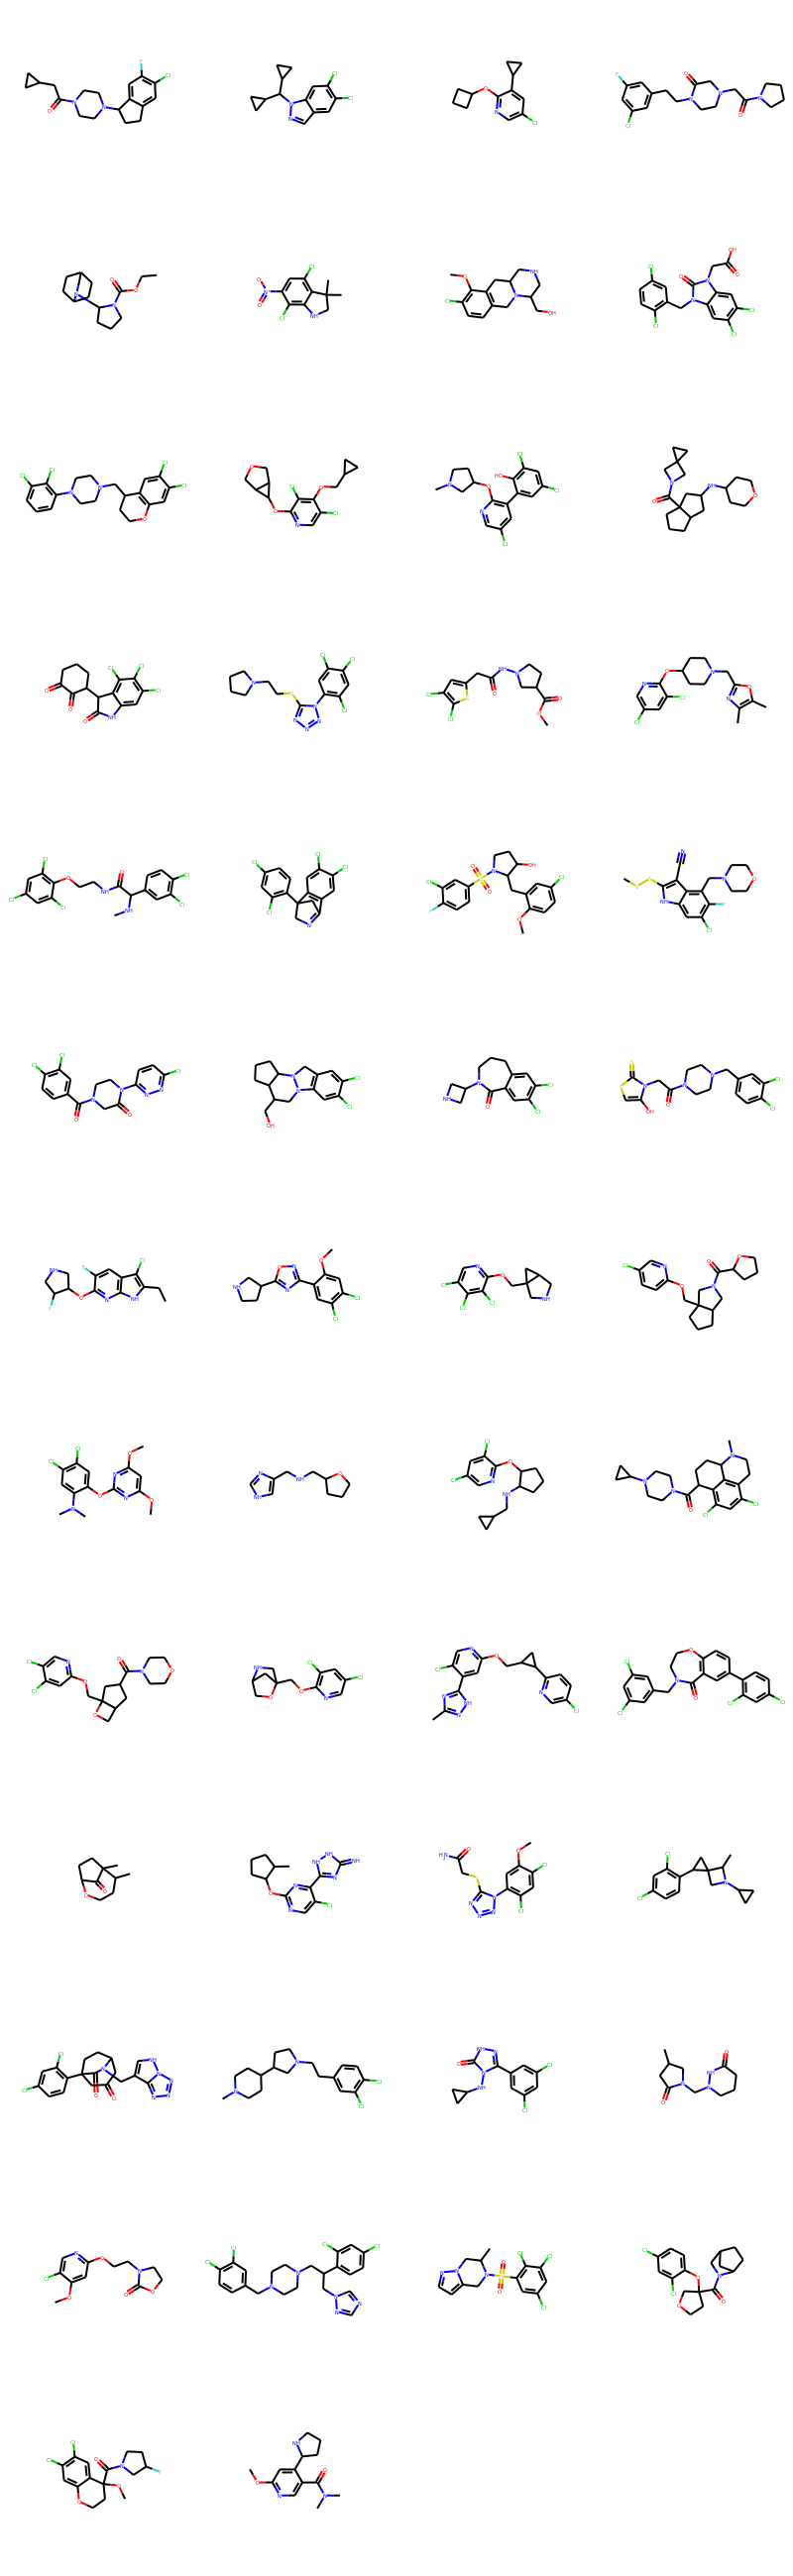

In [43]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools
#gen_smi = Chem.SmilesMolSupplier(os.path.join(output_dir_sampling,"sampled/sampled.smi"))
df = pd.read_csv (os.path.join(output_dir_sampling,"sampled/sampled.smi"))
df.columns = ['smiles']
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
PandasTools.FrameToGridImage(df, molsPerRow=4)